In [1]:
import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# add the path to my packages to system paths so they can be imported
import sys
# sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/simgraph/code/my_packages')
sys.path.append('F:/Users/yasam/Documents/GitHub/simgraph/code/my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import dataprocess.data_handler_03 as dh
import simgraph.my_simgraph as sg

# Load spike data

Spike data shape:  (297, 1141, 113) $\implies$ (movie repeats, frames/time, neurons)
<br>
Labels are 1 (= spike) or -1 (= no spike).

In [5]:
# load all spike data from file
spikes_dp = '../../../local_data/original_files/'
binned_data = np.load(spikes_dp+'spikes.npy')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

In [6]:
I_order = np.array([ 54,  35,  10,  60,  74,   9,  61,  56,  91, 104,  39,   7,  29,  68,  81,  41,  75 , 76,
   82,  79,  32,  51,  14,  88,  89,   8, 107,   3,  80,  55, 106,  96,  94, 95,   6,  20,
   83,  87,   1,  97, 103,  28,  18,  16,  85, 101,   2,  52,  11,  71, 108,  38,  25,  53,
  113,  64,  58,  24,  70,  43,  77,  45, 110,  49,  26,  40,  48,  67, 100,  30,  19,  36,
   17,   5,  69,  65,  99, 78,  33,  37,  47,  66,  59,  98,  21,  90,  12,  46,  86,  92,
    4, 112,  62,  50, 105,  27,  13,  93, 102,  63,  34,  31,  84,  23,  44,  15, 109, 111,
   72,  73,  42,  57,  22])
I_order = I_order - 1

In [7]:
# print some statistics
print('binned_data.shape = ', binned_data.shape)

avg_spike_perc = 0
print('neuron #    | percentage belonging to class 1')
print('---------------------------------------------')
for neu_i in I_order[:10]:
    pers = dh.class_percentages(binned_data[:,:,neu_i].reshape(-1), [-1, 1])
    avg_spike_perc += pers[1]
    print('neuron #{:3} | {:.2f} %'.format(neu_i, pers[1]))

avg_spike_perc /= 10
print('---------------------------------------------')
print('AVERAGE     | {:.2f} % of data belongs to class 1'.format(avg_spike_perc))

total_perc = np.sum(binned_data == 1) * 100 / len(binned_data.reshape(-1))
print('---------------------------------------------')
print('{:.2f} % of the whole data belongs to class 1.'.format(total_perc))

binned_data.shape =  (297, 1141, 113)
neuron #    | percentage belonging to class 1
---------------------------------------------
neuron # 53 | 0.44 %
neuron # 34 | 0.37 %
neuron #  9 | 0.64 %
neuron # 59 | 0.50 %
neuron # 73 | 0.78 %
neuron #  8 | 1.03 %
neuron # 60 | 1.42 %
neuron # 55 | 0.28 %
neuron # 90 | 0.29 %
neuron #103 | 0.97 %
---------------------------------------------
AVERAGE     | 0.67 % of data belongs to class 1
---------------------------------------------
3.00 % of the whole data belongs to class 1.


# Create a correlation matrix

In [23]:
cell_obs = np.transpose(binned_data, axes=(2,0,1)).reshape((113, 297*1141))

In [44]:
corrmat = np.corrcoef(cell_obs)
corrmat.shape

(113, 113)

In [45]:
# make all diagonal elements zero
for i in range(corrmat.shape[0]):
    for j in range(i, corrmat.shape[1]):
        corrmat[i,j] = 0

Text(0.5, 1.0, 'Correlation Matrix')

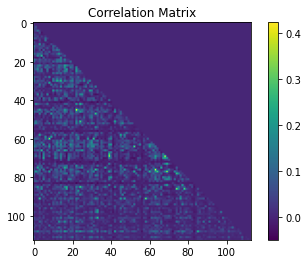

In [46]:
plt.figure()
plt.imshow(corrmat)
plt.colorbar()
plt.title('Correlation Matrix')

# Group highly correlated cells together

In [47]:
sz = corrmat.shape[0]
thresh = 0.3

xloc = np.broadcast_to(np.arange(sz), (sz, sz))
yloc = xloc.T

In [49]:
highcorrpairs = list(zip(xloc[corrmat > thresh],yloc[corrmat > thresh]))

In [69]:
highunique = np.unique(np.array(highcorrpairs).reshape(-1))

In [71]:
group1 = []
for c in highunique:
    group1.append(cell_obs[c, :])
group1 = np.array(group1)

In [72]:
group1.shape

(20, 338877)

In [73]:
corrmat1 = np.corrcoef(group1)
corrmat1.shape

(20, 20)

In [74]:
# make all diagonal elements zero
for i in range(corrmat1.shape[0]):
    for j in range(i, corrmat1.shape[1]):
        corrmat1[i,j] = 0

Text(0.5, 1.0, 'Correlation Matrix')

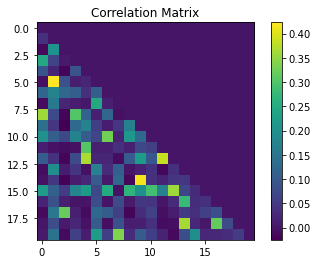

In [75]:
plt.figure()
plt.imshow(corrmat1)
plt.colorbar()
plt.title('Correlation Matrix')

In [53]:
cell_obs_new = cell_obs.copy()
for (c1, c2) in highcorrpairs:
    cell_obs_new[c1, :] = cell_obs_new[c1, :] + cell_obs_new[c2, :]
    cell_obs_new = np.delete(cell_obs_new, c2, 0)

In [54]:
cell_obs_new.shape

(100, 338877)

Text(0.5, 1.0, 'New Correlation Matrix')

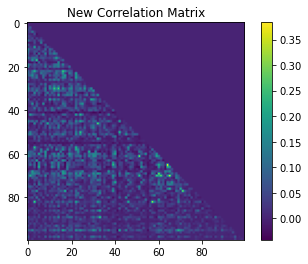

In [56]:
corrmat_new = np.corrcoef(cell_obs_new)

# make all diagonal elements zero
for i in range(corrmat_new.shape[0]):
    for j in range(i, corrmat_new.shape[1]):
        corrmat_new[i,j] = 0

plt.figure()
plt.imshow(corrmat_new)
plt.colorbar()
plt.title('New Correlation Matrix')

# Test area

In [18]:
a.reshape((5, 3*4))

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
       [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
       [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]])

In [22]:
np.transpose(a, axes=(2,0,1)).reshape((5, 3*4))

array([[ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55],
       [ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56],
       [ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57],
       [ 3,  8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58],
       [ 4,  9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59]])